<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF) - Part a): data products</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  09/18/2023 <br>
LSST Science Pipelines version: w_2023_37  <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** A demonstration on accesing `calexp` and `deepCoadd` PSF properties.

**Skills:** Use of single-epoch and coadded PSF models.

**LSST Data Products:**   DP0.2 collection: `2.2i/runs/DP0.2`. Dataset types: `calexp`, `deepCoadd`.  Catalogs: `dp02_dc2_catalogs.Object`, `dp02_dc2_catalogs.Source`.

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools, lsst.pipe.base

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Jeff Carlin, Ryan Lau, and the Rubin Community Science Team for DP0.2. The functions for studying the PSF image profile are built upon the rapid-analysis code originally created by Merlin Fisher-Levine to characterize the Point Spread Function (PSF) of the Rubin Auxiliary Telescope LSST Atmospheric Transmission and Slitless Spectrograph (LATISS) images. 

This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

The Point Spread Function (PSF) can be understood as a function that describes how a bundle of rays, initially converging on a single point, spreads out spatially around that point. To accurately characterize the PSF, it is common to analyze the observed images of stars, which act as point sources before being distorted by the PSF. This analysis helps determine the convolution kernel, representing the size and shape of the blurring effect caused by the PSF. Accurate PSF modeling is crucial because any inaccuracies can lead to erroneous conclusions about fundamental aspects of the universe, such as the properties of dark matter and dark energy. Therefore, understanding and characterizing the PSF is essential to properly interpret and extract reliable cosmological information from astronomical observations.

This tutorial (Section 2) produces an image of the PSF model at a specific location in `calexp` and `deepCoadd` images. It then demonstrates how to calculate PSF profiles and contours, along with other properties such as size.

#### Additional Resources

Point Spread Function Extractor, [PSFEx](https://ui.adsabs.harvard.edu/abs/2013ascl.soft01001B/abstract)

[PIFF (PSF in the Full-Field of View)](https://rmjarvis.github.io/Piff/_build/html/index.html)

### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container.

[treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree)). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from scipy.optimize import curve_fit
from matplotlib import cm
from numpy.linalg import norm
from matplotlib.ticker import LinearLocator
from matplotlib.offsetbox import AnchoredText
from scipy.stats import skew

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.pipe.base as pipeBase
from lsst.rsp import get_tap_service
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees

### 1.2 Functions and Parameters Definitions

The following cell will set a standard figure size and `afwDisplay` backend to use throughout the notebook.

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

The following functions and parameters are defined once, and used throughout this notebook.

**Constant**: `SIGMATOFWHM` 

Defines the convertion factor between the standard deviation `sigma` of a Gaussian function a the full-withd at half-maximum (FWHM): $2\sqrt{2\ln(2)}$

**Function**: `gauss`

Defines a one-dimensional Gaussian profile.

In [4]:
SIGMATOFWHM = 2.0*np.sqrt(2.0*np.log(2.0))


def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

**Function**: `getPsfProperties`

Given a PSF model `lsst.meas.extensions.psfex.PsfexPsf` and a coordinate where the model is being evalualted, `lsst.geom.Point2D`, this functions returns the PSF FWHM, flux from aperture photometry, peak value of the normalized PSF (the PSF is normalized to sum one), and size of the PSF postage stamp.

In [5]:
def getPsfProperties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
        fwhm : `float`
            Full-width at half maximuan: PSF determinat radius
            from SDSS adaptive moments matrix (sigma) times
            SIGMATOFWHM.
        ap_flux : `float`
            PSF flux from aperture photometry weighted
            by a sinc function.
        peak : `float`
            Peak PSF value.
        dims : `lsst.geom.ExtendI`
            PSF postage stamp dimensions.
    """
    sigma = psf.computeShape(point).getDeterminantRadius()
    fwhm = sigma * SIGMATOFWHM
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    dims = psf.computeImage(point).getDimensions()

    print(f"PSF FWHM: {fwhm:.4} pix \n"
          f"PSF flux from aperture photometry: {ap_flux:.4} \n"
          f"Peak PSF value: {peak:.4} \n"
          f"PSF postage stamp dimensions: {dims} \n")

    return (sigma, ap_flux, peak, dims)

**Function**: `plotRadialAverage`

Plots the azimuthally-averaged radial profile of the PSF, and fits a Gaussian function to it.

In [6]:
def plotRadialAverage(exp, ax=None):
    """
    Function to plot the radial average of a point spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape
    center = np.array([xlen / 2, ylen / 2])
    distances = []
    values = []

    for i in range(xlen):
        for j in range(ylen):
            value = data[i, j]
            dist = np.linalg.norm(np.array([i, j]) - center)
            if dist <= xlen / 2:
                values.append(value)
                distances.append(dist)

    peakPos = 0
    amplitude = np.max(values)
    width = 10

    bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

    try:
        pars, pCov = curve_fit(gauss, distances, values,
                               [amplitude, peakPos, width], bounds=bounds)
        pars[0] = np.abs(pars[0])
        pars[2] = np.abs(pars[2])
    except RuntimeError:
        pars = None

    if ax is None:
        ax = plt.gca()

    ax.plot(distances, values, 'x', label='Radial average')

    if pars is not None:
        fitAmp = pars[0]
        fitGausMean = pars[1]
        fitFwhm = pars[2] * SIGMATOFWHM
        fitline = gauss(distances, *pars)

        x_fit = np.linspace(-np.max(distances), np.max(distances), 100)
        y_fit = gauss(x_fit, *pars)
        skewness = skew(y_fit, axis=0, bias=True)

        ax.plot(distances, fitline,
                label=f" Gaussian Fit \n Amp: {fitAmp:.3f}"
                      f"\n Position: {fitGausMean:.2f}"
                      f"\n FWHM: {fitFwhm:.2f}"
                      f"\n \n Skeness: {skewness:.2f}")

    ax.set_ylabel('Flux (ADU)')
    ax.set_xlabel('Radius (pix)')
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
    ax.legend()
    ax.set_title("Azimuthally-averaged radial profile")

    return ax

**Function**: `plotCurveOfGrowth`

Plots the encircled energy ofthe PSF as a function of radius (curve of growth).

In [7]:
def plotCurveOfGrowth(exp, ax=None):
    """
    Function to plot the curve of growth of a point
    spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape
    center = np.array([xlen / 2, ylen / 2])
    distances = []
    values = []

    for i in range(xlen):
        for j in range(ylen):
            value = data[i, j]
            dist = np.linalg.norm(np.array([i, j]) - center)
            if dist <= xlen / 2:
                values.append(value)
                distances.append(dist)

    d = np.array([(r, v) for (r, v) in sorted(zip(distances, values))])
    radii = d[:, 0]
    values = d[:, 1]
    cum_fluxes = np.cumsum(values)
    cum_fluxes_norm = cum_fluxes / np.max(cum_fluxes)

    if ax is None:
        ax = plt.gca()

    ax.plot(radii, cum_fluxes_norm, markersize=10)
    ax.set_ylabel('Encircled flux (%)')
    ax.set_xlabel('Radius (pix)')
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
    ax.set_title("Encircled flux")

    return ax

**Function**: `plotContours` 

Plots the two-dimensional contous of the PSF postage stamp.

In [8]:
def plotContours(exp, ax=None, nContours=10):
    """
    Function to plot contour lines of a point spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).
    nContours : int, optional
        The number of contour lines to plot (default is 10).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape

    vmin = np.percentile(data, 0.1)
    vmax = np.percentile(data, 99.9)
    lvls = np.linspace(vmin, vmax, nContours)

    xx, yy = np.meshgrid(np.arange(-xlen / 2, xlen / 2),
                         np.arange(-ylen / 2, ylen / 2))

    if ax is None:
        ax = plt.gca()

    ax.contour(xx, yy, data, levels=lvls)
    ax.tick_params(which="both", direction="in", top=True,
                   right=True, labelsize=8)
    ax.set_aspect("equal")
    ax.set_xlabel('x (pix)')
    ax.set_ylabel('y (pix)')
    ax.set_title("Contour plot")

    return ax

### 2. PSF image manipulation in `calexp` and `deepCoadd` images.

#### How are PSFs measured by the LSST Science Pipelines

1. The initial stage in processing LSST science observations involves Instrument Signature Removal (ISR). This encompasses fundamental detrending operations like flat-fielding, bias subtraction, fringe correction, and rectification of flawed and oversaturated pixels. 

2. Subsequently, the focus shifts to characterizing single-epoch direct images, constructing models that depict the observational system and its conversion of the true celestial scene into the observed image. This process encompasses background subtraction, PSF modeling, addressing cosmic ray effects, applying aperture corrections, and source measurement. 

3. After segregating stars and galaxies, the PSF model in single-epoch images is assembled using data from a star catalog. 

The LSST Science Pipelines have partially transitioned to using the [PIFF (PSF in the Full-Field of View)](https://rmjarvis.github.io/Piff/_build/html/index.html) code for PSF modeling in the full field of view. However, the DP0.2 PSF models were generated using the Point Spread Function Extractor, [PSFEx](https://ui.adsabs.harvard.edu/abs/2013ascl.soft01001B/abstract), software.  

In the forthcoming sub-sections, images of the PSF model at a specific location within both a `calexp` and a `deepCoadd` image will be generated. 

#### 2.1 PSF in `calexp` images.

Define the Butler instance for DP0.2 and select a particular single `calexp` image. Select the same image used in section 2 of DP0.2 Notebook Tutorial 3a. Pass the `visit` and `detector` numbers in order to uniquely constrain the image, and visualize the image afterwards.

In [9]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collections)

In [10]:
datasetType = 'calexp'
dataId = {'visit': 192350, 'detector': 175}
calexp = butler.get(datasetType, dataId=dataId)

The following plot is a 2D image of the `calexp` from the previous butler query, in pixel coordinates ranging from 0 to 4000 pixels in both axes, and with a contrast bar ranging from -300 to 400 digital units. Point and extended sources are scattered around the image. We will retrieve PSF models at particular points in this image.

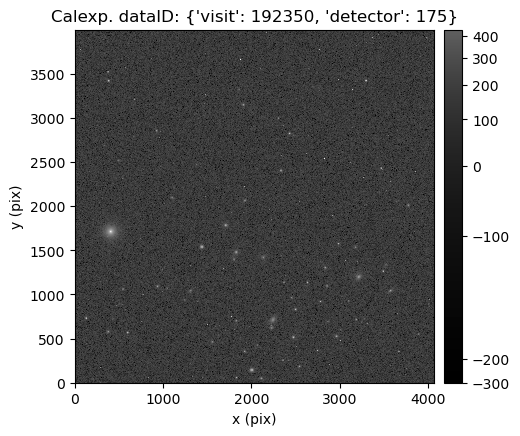

In [11]:
fig = plt.figure(figsize=(5, 5))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.title(f'Calexp. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

Extract the PSF model from the exposure information, obtained from the `calexp` object itself.

In [12]:
info_calexp = calexp.getInfo()
psf_calexp = info_calexp.getPsf()

##### 2.1.1 Basic `calexp` PSF properties

Pick a specific point in the image with coordinates `(x, y) = (2000, 3500)` (indicated by the `point_tuple` variable) and utilize the PSF model along with the `getPsfProperties` helper function to obtain PSF properties, including size, aperture photometry flux, peak flux value, and dimensions of the PSF postage stamp.

In [13]:
point_tuple = (2000, 3500)
point_image = Point2D(point_tuple)

In [14]:
props = getPsfProperties(psf_calexp, point_image)

PSF FWHM: 3.795 pix 
PSF flux from aperture photometry: 0.3659 
Peak PSF value: 0.05834 
PSF postage stamp dimensions: (41, 41) 



The calculated PSF size corresponds to the full-width at half-maximum (FWHM) after applying the conversion factor `SIGMATOFWHM` defined earlier. The PSF is normalized to a sum of one, and its dimensions match those of a postage stamp containing the PSF, as illustrated in the sections below. The peak value signifies the highest normalized PSF value within the image.

##### 2.1.2 `computeKernelImage` vs `computeImage`

Use the `computeKernelImage` method to display the pixel-based model of the PSF at the same specific point selected above (`point_tuple` variable). 

In [15]:
psf_calexp_kernel = psf_calexp.computeKernelImage(point_image)
first_psf_image_calexp = psf_calexp_kernel.convertF()

The subsequent plot depicts a postage stamp or cut-out of a PSF model extracted from a `calexp` image using the `computeKernelImage` function. The PSF is centered at the origin, and the stamp is rectangular, encompassing 40 pixels and spanning from negative 20 to positive 20 pixels on each side. The color contrast bar spans a range from approximately negative 0.0002 to about 0.0003.

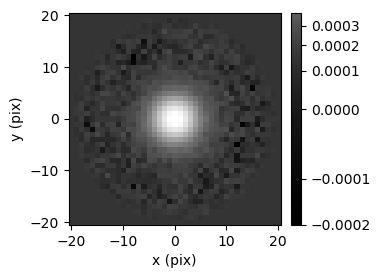

In [16]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_calexp)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

Note that the image coordinates are centered at the origin of the image. The coordinates of this origin point are (0,0), resulting in negative coordinates for the lower left point:

In [17]:
print(first_psf_image_calexp.getXY0())

(-20, -20)


Now, instead of using `computeKernelImage`, utilize `computeImage`. The former positions the PSF center at the center of the central pixel within the stamp or cutout (`computeKernelImage`). On the other hand, the latter (`computeImage`) allows the PSF center to be placed at any arbitrary location. 

To achieve this, the astrometric solution, often referred to as the "World Coordinate System" (WCS) in the code, is needed. It maps pixel coordinates to sky coordinates and can also be obtained form the exposure information, as the PSF model. The "WCS" nomenclature is used for historical reasons. Note also that the `point_tuple` variable needs to be converted into an `lsst.geom.Point2D` object first. 

In [18]:
wcs_calexp = info_calexp.getWcs()
point_object = Point2D(point_tuple)
second_psf_image_calexp = psf_calexp.computeImage(point_object).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `calexp`, obtained using `computeKernelImage`. The PSF is centered around (2000, 3500), and the stamp is rectangular, with a size of 40 pixels, ranging from 1980 to 2020 pixels on the `x` axis and from about 3480 to 3520 on the `y` axis. The contrast bar ranges from negative 0.0002 to about 0.0003. 

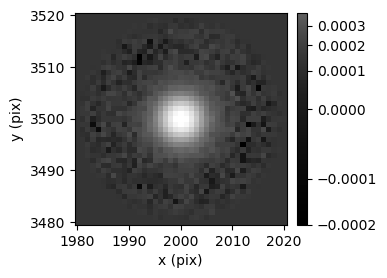

In [19]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_calexp)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

Check again the coordinates for the lower left point in the previous image:

In [20]:
print(second_psf_image_calexp.getXY0())

(1980, 3480)


#### 2.2 PSF in `deepCoadd` images.

**Context**: When conducting multi-epoch surveys for static-sky science, the traditional method involves creating coadds. This process entails resampling images from different observations onto a common grid and averaging them to generate a single, deeper image known as a `deepCoadd`. Additionally, a coadded point spread function (PSF) model is established. Handling PSF coadding with care is crucial to ensure a well-defined PSF.

One of the challenges in coadding PSFs arises from slight variations observed between PSFs in different visits. Even minor differences make it practically impossible to accurately model the effective PSF of the coadd using coadded star images. Even small positional shifts, known as dithers, used to fill the gaps between charge-coupled devices introduce disruptions in the effective PSF of the coadd. As the number of dithers increases, the areas within the coadd with a continuous effective PSF become smaller, making it increasingly unlikely to find stars suitable for PSF modeling in each region. For the Hyper-Suprime Camera survey, [Bosch et al 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) use an approach that involves resampling and combining existing PSF models from the input images using the same coordinate transformations and weights applied to the image data. The Hyper-Suprime Camera survey analysis pipeline is based on the LSST Science Pipelines code.

Visualize first the PSF model in a `deepCoadd` image similar to section 2.1, but this time using a `deepCoadd` image. 

Select the same point in the sky that we used to represent the PSF in the `calexp` of the previous section, to better appreciate the differences between the `deepCoadd` and an individual `calexp` PSF model.

First, retrieve the right ascension and declination coordinates of the point we used in the previous section (stored in the variable `point_tuple`), as well as the band of that exposure. Then, follow the steps outlined in section 3.2 of the Notebook tutorial `DP02_01` to determine the `tract` and `patch` of the `deepCoadd`. 

In [21]:
x, y = point_tuple
ra, dec = wcs_calexp.pixelToSky(x, y)
my_ra_deg = radToDeg(ra)
my_dec_deg = radToDeg(dec)
print(my_ra_deg, my_dec_deg)

53.01240743567535 -34.1195835309739


The previous information, along with the `band`, will uniquely define a data ID that we can provide to the butler to access the corresponding `deepCoadd`.

In [22]:
my_band = info_calexp.getFilter().bandLabel
print(my_band)

i


Pass both the `tract` and `patch` numbers, along with the desired band (`i`), to uniquely specify the image we're interested in.

In [23]:
my_spherePoint = SpherePoint(my_ra_deg*degrees,
                             my_dec_deg*degrees)
print(my_spherePoint)

skymap = butler.get('skyMap')

tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

(53.0124074357, -34.1195835310)
my_tract:  4225
my_patch:  3


In [24]:
datasetType = 'deepCoadd'
dataId = {'tract': my_tract, 'patch': my_patch, 'band': my_band}
coadd = butler.get(datasetType, dataId=dataId)

The following plot is a 2D image of the `deepCoadd` from the previous butler query, in pixel coordinates ranging from 12000 to 16000 pixels in the horizontal axis and 0 to 4000 pixels in the vertical axis. The contrast bar ranges from negative 0.2 to 0.3 digital units. Point and extended sources are scattered around the image.

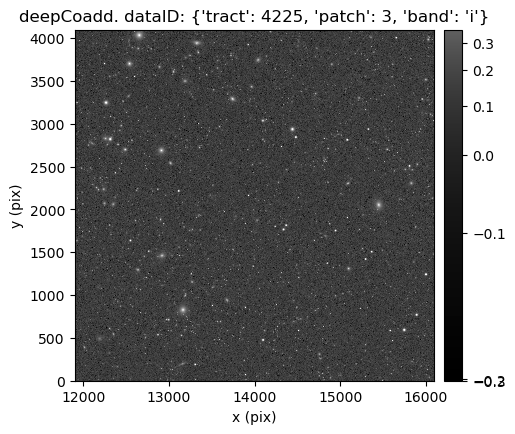

In [25]:
fig = plt.figure(figsize=(5, 5))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title(f'deepCoadd. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

Extract the PSF model from the exposure information, obtained from the `cdeepCoadd` object itself.

In [26]:
info_coadd = coadd.getInfo()
psf_coadd = info_coadd.getPsf()

##### 2.1.1 Basic `deepCoadd` PSF properties

Use the same specific point in the image with coordinates `(x, y) = (2000, 3500)` as above.

In order to use the same point as in the example above with the `calexp`, retrieve first the WCS for the coadd information, and convert the sky point to local pixel coordinates in the `deepCoadd` image displayed in the previous cell.  

In [27]:
wcs_coadd = info_coadd.getWcs()
point_image = wcs_coadd.skyToPixel(my_spherePoint)
point_image

Point2D(12937.473803968331, 2324.9666227765465)

Utilize the PSF model along with the `getPsfProperties` helper function to obtain PSF properties, including size, aperture photometry flux, peak flux value, and dimensions of the PSF postage stamp.

In [28]:
props_psf_coadd = getPsfProperties(psf_coadd, point_image)

PSF FWHM: 4.121 pix 
PSF flux from aperture photometry: 0.3591 
Peak PSF value: 0.0492 
PSF postage stamp dimensions: (57, 57) 



##### 2.1.2 `computeKernelImage` vs `computeImage`

Use `computeKernelImage` to display the pixel-based model of the PSF at a particular point. Note the higher signal-to-noise ratio in this image, compared to the single `calexp` PSF image in Section 2.1

In [29]:
psf_kernel_coadd = psf_coadd.computeKernelImage(point_image)
first_psf_image_coadd = psf_kernel_coadd.convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of about 50 pixels, ranging from -25 to 25 pixels on each size. The contrast bar ranges from -1e-5 to 7e-5 . 

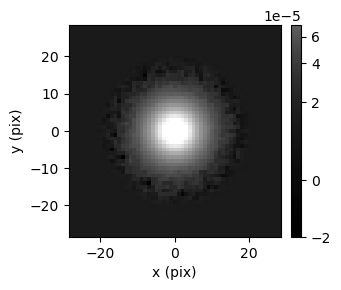

In [30]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_coadd)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

Print the coordinates of the lower-left corner:

In [31]:
print(first_psf_image_coadd.getXY0())

(-28, -28)


Now, instead of `computeKernelImage`, use
`computeImage`. 

One has the PSF center at the center of the 
central pixel in the stamp or cutout (computeKernelImage), and 
the other one (computeImage) can make it at any arbitrary location.

In [32]:
second_psf_image_coadd = psf_coadd.computeImage(point_image).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeImage`. The PSF is no longer centered around zero as when we used `computeKernelImage`, but centered at about 13000 and 2325 pixels. The stamp is still rectangular, with a size of about 50 pixels, ranging from 12970 to 12970 pixels on the horizantal axis and 2250 to 2350 on the vertical axis. The contrast bar ranges from negative 1e-5 to 7e-5 .

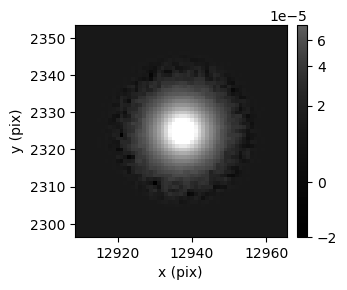

In [33]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_coadd)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

Look at the coordinates of the lower-left corner:

In [34]:
second_psf_image_coadd.getXY0()

Point2I(12909, 2297)

#### 2.3.  PSF properties for rapid analysis.

Use the functions  `plotRadialAverageplotRadialAverage`, `plotCurveOfGrowth`, and `plotContours`, based on image quality code currently employed for the [swift PSF analysis of the LATISS images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) obtained by Rubin's AuxTel at Cerro Pachón, Chile.

##### 2.3.1 Radial profial and Gaussian fit.


Plot an azymuthally-averaged one dimensional PSF profile and fit a Gaussian function to it, for both the `calexp` and `deepCoadd` PSF images. 

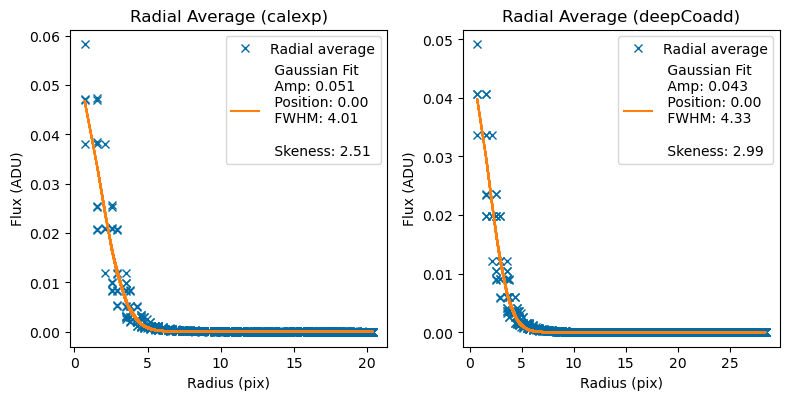

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotRadialAverage(first_psf_image_calexp, ax=axes[0])
ax1.set_title("Radial Average (calexp)")
ax2 = plotRadialAverage(first_psf_image_coadd, ax=axes[1])
ax2.set_title("Radial Average (deepCoadd)")
plt.tight_layout()
plt.show()

##### 2.3.2  Contour plots

Create contour lines on the PSF image. These contour lines depict regions of equal brightness. 

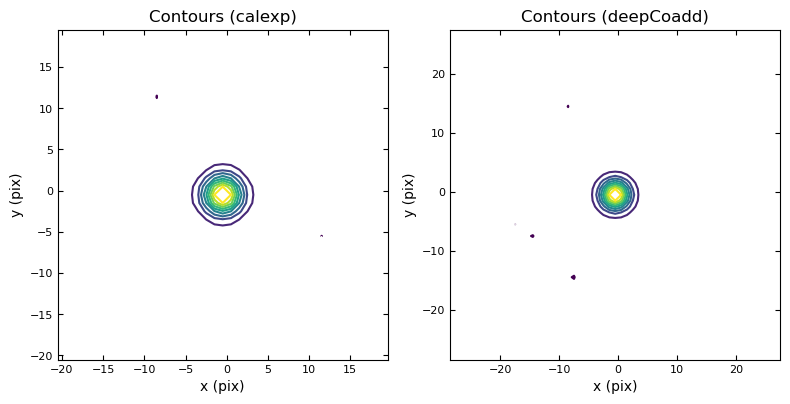

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotContours(first_psf_image_calexp, ax=axes[0])
ax1.set_title("Contours (calexp)")
ax2 = plotContours(first_psf_image_coadd, ax=axes[1])
ax2.set_title("Contours (deepCoadd)")
plt.tight_layout()
plt.show()

##### 2.3.3 Encircled energy 

Calculate the cumulative amount of light enclosed by successively larger radii from the center of the PSF. This cumulative light measurement is normalized to the total light, resulting in a curve that reveals how light accumulates with increasing distance from the PSF center. 

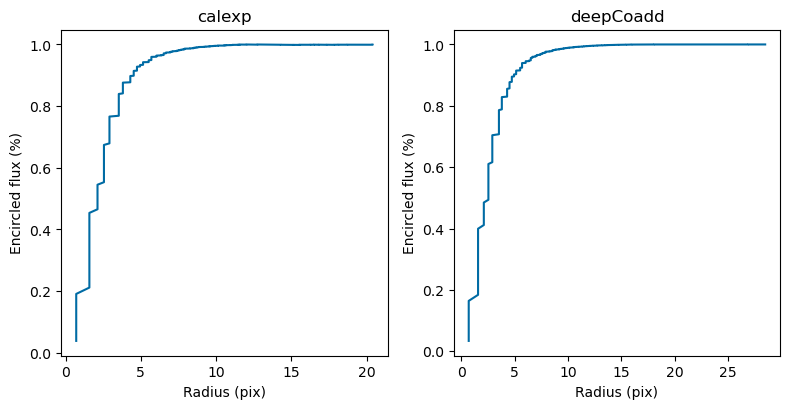

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotCurveOfGrowth(first_psf_image_calexp, ax=axes[0])
ax1.set_title("calexp")
ax2 = plotCurveOfGrowth(first_psf_image_coadd, ax=axes[1])
ax2.set_title("deepCoadd")
plt.tight_layout()
plt.show()

### Exercise for the Learner

* The function `plotRadialAverageplotRadialAverage` uses a Gaussian function to fit the averaged PSF profile. Use a different functional form for fitting the one-dimensional PSF radial profiles, such as the Moffat profile (as described in section 3.1 of [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).